In [1]:
# In[1]: Imports and Environment Setup
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Try XGBoost, fall back to scikit-learn GBM
try:
    from xgboost import XGBClassifier
    GBM = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    param_dist = {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'gamma': [0, 0.1, 0.5]
    }
except ImportError:
    from sklearn.ensemble import GradientBoostingClassifier
    GBM = GradientBoostingClassifier(random_state=42)
    param_dist = {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7]
    }


In [5]:
# In[2]: Load & Sanitize Data for One Region
file_path = r"C:\Users\paulw\Documents\NeuroSignalProject\Patient1_Hippo_6.csv"
df = pd.read_csv(file_path)

# Sanitize all column names: remove brackets, spaces, etc.
df.columns = [re.sub(r'[^0-9A-Za-z_]', '_', col) for col in df.columns]


In [ ]:
import ast
import numpy as np

def to_floats(cell):
    if isinstance(cell, str):
        cell = ast.literal_eval(cell)
    return [float(v) for v in cell]

fr_cols = [c for c in df.columns if c.startswith('FR_neuron')]

# Convert each column’s lists to float‐lists in place
for col in fr_cols:
    df[col] = df[col].apply(to_floats)

# Now compute the per‐trial mean for each neuron
for col in fr_cols:
    df[col + '_mean'] = df[col].apply(lambda rates: np.mean(rates) if rates else 0.0)

In [13]:
y=df['acc_bin']
X=df.drop(['trial_id', 'Accuracy', 'acc_bin'], axis=1)

In [8]:
mean_cols = [c for c in df.columns if c.endswith('_mean')]
X = df[mean_cols].copy()

In [28]:
# In[5]: Stratified Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [29]:
# In[6]: Upsample Minority Class in Training Set
train_df = pd.concat([X_train, y_train.rename('label')], axis=1)
maj = train_df[train_df['label']==train_df['label'].mode()[0]]
minr = train_df[train_df['label']!=train_df['label'].mode()[0]]
minr_up = resample(minr, replace=True, n_samples=len(maj), random_state=42)
train_bal = pd.concat([maj, minr_up])
X_train_bal = train_bal.drop('label', axis=1)
y_train_bal = train_bal['label']


In [30]:
# In[7]: Hyperparameter Tuning with RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    GBM, param_distributions=param_dist, n_iter=20,
    scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42
)
search.fit(X_train_bal, y_train_bal)
best_model = search.best_estimator_


In [31]:
# In[8]: Evaluation on Test Set
y_pred  = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Best params:", search.best_params_)
print("Test ROC AUC:", roc_auc_score(y_test, y_proba), "\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual_0','Actual_1'], columns=['Pred_0','Pred_1'])
print("Confusion Matrix:\n", cm_df)


Best params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
Test ROC AUC: 0.3333333333333333 

              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.57      0.67      0.62         6

    accuracy                           0.50        10
   macro avg       0.45      0.46      0.45        10
weighted avg       0.48      0.50      0.48        10

Confusion Matrix:
           Pred_0  Pred_1
Actual_0       1       3
Actual_1       2       4


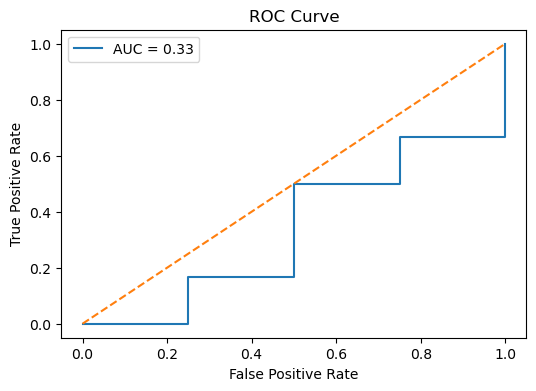

In [32]:

# In[9]: ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
